<a href="https://colab.research.google.com/github/Ikeda33/codespaces-railstutorial/blob/main/selfattention3_50epoch_flower_D_sa_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 13.6 MB/s eta 0:00:00


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 389MB/s]


In [13]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=50, batch_size=32, lr_g=0.0002, lr_d=0.0003, nch_g=64, nch_d=64, z_dim=100, beta1=0.5)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform


    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([

    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),

        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),

    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z)
        z = self.relu(z)

        z = self.conv2(z)
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2\n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels)\n        self.bn = n

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding\n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)


    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x

    def forward(self, x):

        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity


        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x)


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)

        return x

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)

    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels

        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE_G(out_channels))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))



        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.convt1(x)

        out = self.convt2(out)

        out = self.convt3(out)

        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf , attention = True)
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf, attention = True )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf, attention = True)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)


    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)

        out = self.conv3(out)

        out = self.conv4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [01:50<00:00,  1.08s/it]


epoch: 0, lossD:1.3126055270578096, lossG:19.943625084404808,lossG_fake:14.556687926783145, lossG_real:5.386937117692336 ,equality:9.169750809090807


evaluate:218.755126953125,kid_mean:0.18426138162612915, kid_std:0.0260139312595129,kid_:(tensor(0.1843), tensor(0.0260))


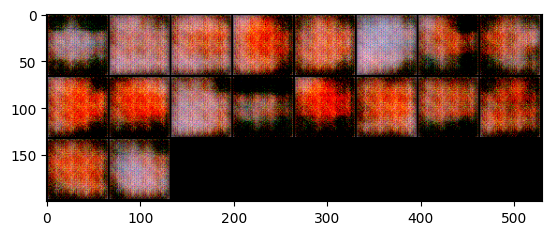

100%|██████████| 103/103 [00:09<00:00, 10.95it/s]


epoch: 1, lossD:0.6774935740796686, lossG:9.348800233266886,lossG_fake:5.38120962173036, lossG_real:3.967590638156076 ,equality:1.4136189835742838


evaluate:150.69329833984375,kid_mean:0.10816705971956253, kid_std:0.03919416666030884,kid_:(tensor(0.1082), tensor(0.0392))


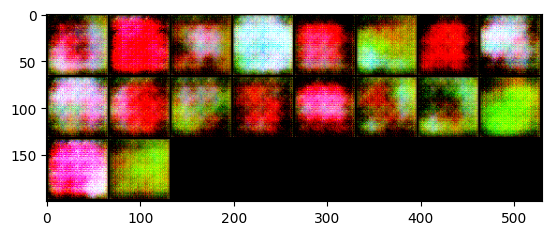

100%|██████████| 103/103 [00:09<00:00, 10.83it/s]


epoch: 2, lossD:1.1791585630294188, lossG:6.900710851243399,lossG_fake:3.941350766177316, lossG_real:2.959360089261555 ,equality:0.9819906769157614


evaluate:138.1278839111328,kid_mean:0.08924384415149689, kid_std:0.0345524437725544,kid_:(tensor(0.0892), tensor(0.0346))


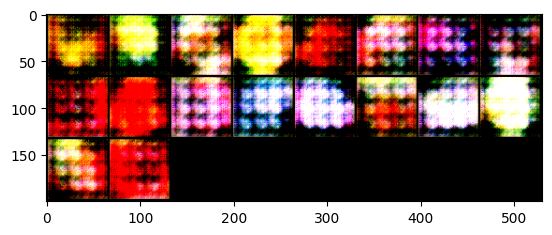

100%|██████████| 103/103 [00:09<00:00, 10.77it/s]


epoch: 3, lossD:1.112643406952469, lossG:7.242909899035704,lossG_fake:4.301454876233073, lossG_real:2.9414550242493456 ,equality:1.3599998519837277


evaluate:145.34849548339844,kid_mean:0.10171803832054138, kid_std:0.040048468858003616,kid_:(tensor(0.1017), tensor(0.0400))


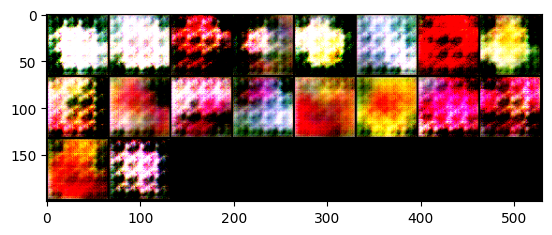

100%|██████████| 103/103 [00:09<00:00, 10.71it/s]


epoch: 4, lossD:1.0798392446295728, lossG:6.948279283579113,lossG_fake:4.07037715310032, lossG_real:2.8779021061739876 ,equality:1.192475046926332


evaluate:141.6813507080078,kid_mean:0.10595499724149704, kid_std:0.049743715673685074,kid_:(tensor(0.1060), tensor(0.0497))


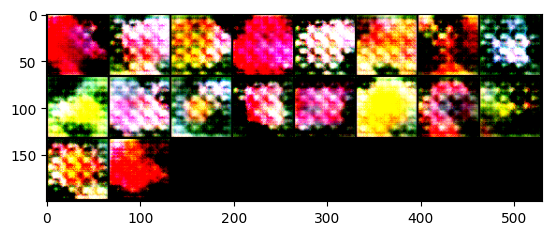

100%|██████████| 103/103 [00:09<00:00, 10.63it/s]


epoch: 5, lossD:1.0366314604733755, lossG:6.801642728083342,lossG_fake:3.9752554216431184, lossG_real:2.826387314831169 ,equality:1.1488681068119493


evaluate:134.2830352783203,kid_mean:0.08950269967317581, kid_std:0.042309727519750595,kid_:(tensor(0.0895), tensor(0.0423))


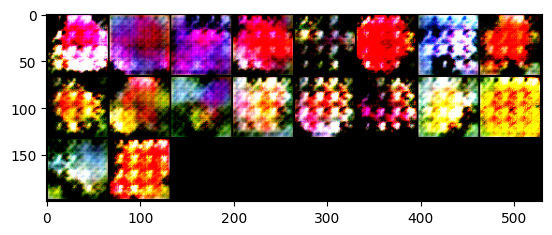

100%|██████████| 103/103 [00:09<00:00, 10.59it/s]


epoch: 6, lossD:1.1258609344803014, lossG:6.202672888931719,lossG_fake:3.5831640808327685, lossG_real:2.619508782926115 ,equality:0.9636552979066533


evaluate:133.2552490234375,kid_mean:0.09190807491540909, kid_std:0.039648741483688354,kid_:(tensor(0.0919), tensor(0.0396))


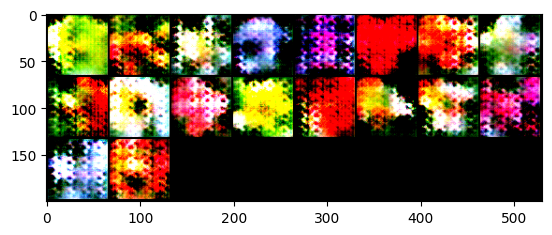

100%|██████████| 103/103 [00:09<00:00, 10.46it/s]


epoch: 7, lossD:0.9882327889643826, lossG:6.501908029167398,lossG_fake:3.8167670421229984, lossG_real:2.6851409858870277 ,equality:1.1316260562359708


evaluate:130.7699737548828,kid_mean:0.08289098739624023, kid_std:0.039379216730594635,kid_:(tensor(0.0829), tensor(0.0394))


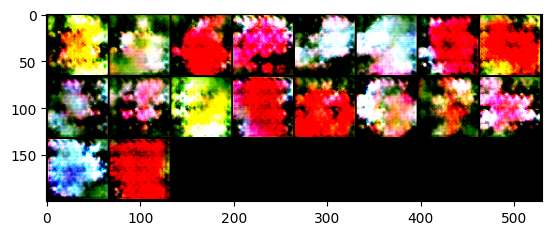

100%|██████████| 103/103 [00:09<00:00, 10.48it/s]


epoch: 8, lossD:0.9932849287118727, lossG:6.5951166939966885,lossG_fake:3.812723708528917, lossG_real:2.7823929763534694 ,equality:1.0303307321754476


evaluate:134.09483337402344,kid_mean:0.08020302653312683, kid_std:0.039289917796850204,kid_:(tensor(0.0802), tensor(0.0393))


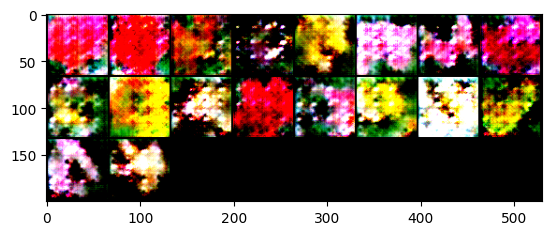

100%|██████████| 103/103 [00:09<00:00, 10.44it/s]


epoch: 9, lossD:1.0273629293858426, lossG:6.51196868674269,lossG_fake:3.7740514822376583, lossG_real:2.737917192931314 ,equality:1.0361342893063443


evaluate:134.42471313476562,kid_mean:0.0807136744260788, kid_std:0.04649658873677254,kid_:(tensor(0.0807), tensor(0.0465))


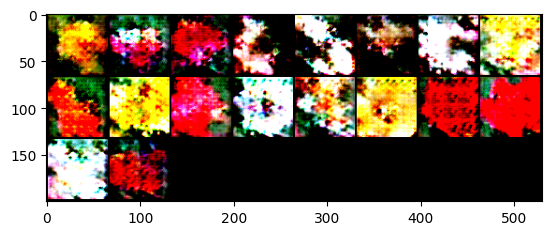

100%|██████████| 103/103 [00:09<00:00, 10.39it/s]


epoch: 10, lossD:1.0257399241322454, lossG:6.414737210690396,lossG_fake:3.622829574983097, lossG_real:2.791907647859703 ,equality:0.8309219271233941


evaluate:141.7769317626953,kid_mean:0.09818737953901291, kid_std:0.04578379914164543,kid_:(tensor(0.0982), tensor(0.0458))


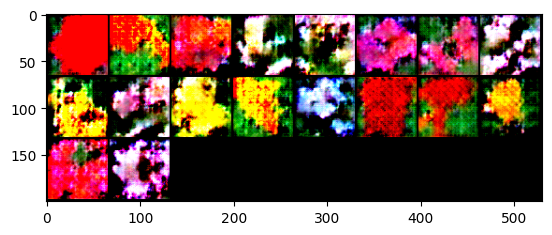

100%|██████████| 103/103 [00:09<00:00, 10.34it/s]


epoch: 11, lossD:1.173974155511671, lossG:6.122543084968641,lossG_fake:3.5152376762871604, lossG_real:2.6073054005798784 ,equality:0.9079322757072821


evaluate:140.9936065673828,kid_mean:0.09266990423202515, kid_std:0.04950372874736786,kid_:(tensor(0.0927), tensor(0.0495))


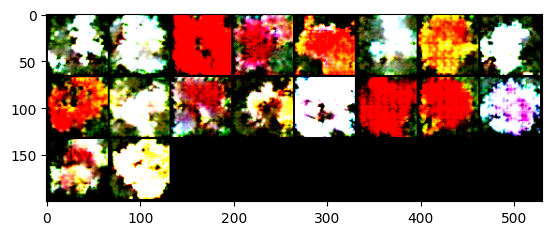

100%|██████████| 103/103 [00:10<00:00, 10.26it/s]


epoch: 12, lossD:1.12491020994279, lossG:5.889005522126133,lossG_fake:3.3342034909331684, lossG_real:2.5548020280101924 ,equality:0.779401462922976


evaluate:137.58502197265625,kid_mean:0.0921202301979065, kid_std:0.047518160194158554,kid_:(tensor(0.0921), tensor(0.0475))


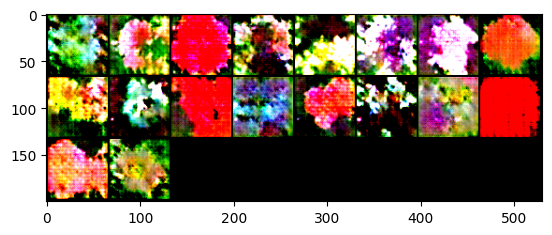

100%|██████████| 103/103 [00:10<00:00, 10.25it/s]


epoch: 13, lossD:1.0542553193071513, lossG:6.111987479682107,lossG_fake:3.3463609230171127, lossG_real:2.7656265508781357 ,equality:0.580734372138977


evaluate:133.2855682373047,kid_mean:0.08618146181106567, kid_std:0.04497377946972847,kid_:(tensor(0.0862), tensor(0.0450))


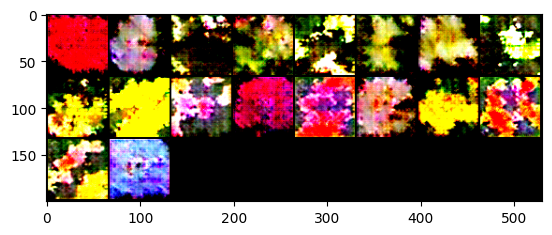

100%|██████████| 103/103 [00:10<00:00, 10.19it/s]


epoch: 14, lossD:1.0756169366605073, lossG:6.048945001028116,lossG_fake:3.4075820411293254, lossG_real:2.641362970315137 ,equality:0.7662190708141883


evaluate:134.71987915039062,kid_mean:0.08677675575017929, kid_std:0.0490974523127079,kid_:(tensor(0.0868), tensor(0.0491))


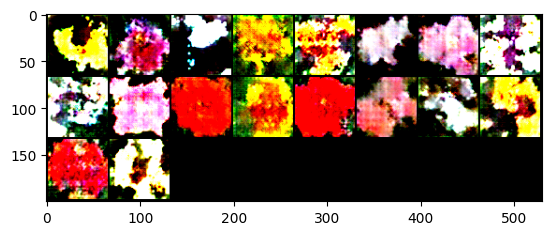

100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


epoch: 15, lossD:0.9530998981982759, lossG:6.385408507967458,lossG_fake:3.5183385842054795, lossG_real:2.867069941701241 ,equality:0.6512686425042387


evaluate:132.2002716064453,kid_mean:0.10200034826993942, kid_std:0.048891834914684296,kid_:(tensor(0.1020), tensor(0.0489))


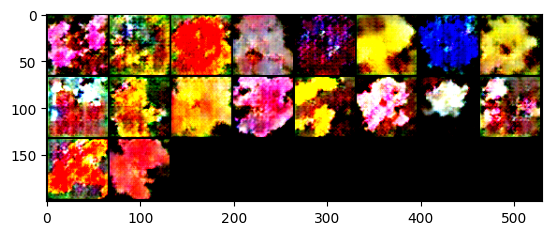

100%|██████████| 103/103 [00:10<00:00, 10.16it/s]


epoch: 16, lossD:0.9631617394755188, lossG:6.342092481631677,lossG_fake:3.46053387007667, lossG_real:2.8815585875395433 ,equality:0.5789752825371268


evaluate:131.29937744140625,kid_mean:0.09053054451942444, kid_std:0.045125409960746765,kid_:(tensor(0.0905), tensor(0.0451))


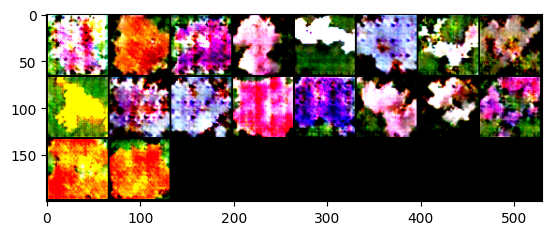

100%|██████████| 103/103 [00:10<00:00, 10.15it/s]


epoch: 17, lossD:0.8013568532119677, lossG:6.648212562486964,lossG_fake:3.58040068913432, lossG_real:3.067811857149439 ,equality:0.512588831984881


evaluate:132.212890625,kid_mean:0.09545142948627472, kid_std:0.04853047430515289,kid_:(tensor(0.0955), tensor(0.0485))


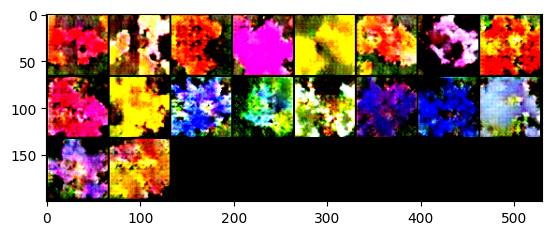

100%|██████████| 103/103 [00:10<00:00, 10.14it/s]


epoch: 18, lossD:0.7293171166505629, lossG:7.002238255102657,lossG_fake:3.7617878138440326, lossG_real:3.2404504325783368 ,equality:0.5213373812656958


evaluate:133.5686492919922,kid_mean:0.08722902089357376, kid_std:0.04526585340499878,kid_:(tensor(0.0872), tensor(0.0453))


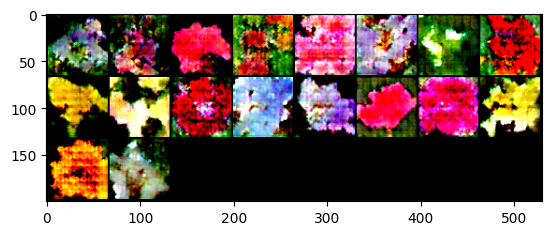

100%|██████████| 103/103 [00:10<00:00, 10.21it/s]


epoch: 19, lossD:0.7686701173197876, lossG:7.220013345329507,lossG_fake:3.963059482065219, lossG_real:3.2569538372234232 ,equality:0.7061056448417959


evaluate:127.27517700195312,kid_mean:0.08540201932191849, kid_std:0.043478455394506454,kid_:(tensor(0.0854), tensor(0.0435))


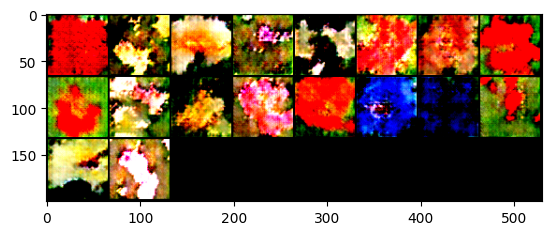

100%|██████████| 103/103 [00:10<00:00, 10.12it/s]


epoch: 20, lossD:0.6052876684127502, lossG:7.421048641204834,lossG_fake:3.9821551505801747, lossG_real:3.438893514929466 ,equality:0.5432616356507087


evaluate:128.52001953125,kid_mean:0.09893621504306793, kid_std:0.05240462347865105,kid_:(tensor(0.0989), tensor(0.0524))


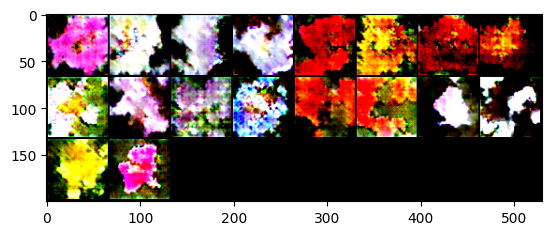

100%|██████████| 103/103 [00:10<00:00, 10.15it/s]


epoch: 21, lossD:0.6681081091316001, lossG:7.743897549157004,lossG_fake:4.176141648616605, lossG_real:3.5677558993830263 ,equality:0.6083857492335789


evaluate:125.32660675048828,kid_mean:0.08552640676498413, kid_std:0.04428848624229431,kid_:(tensor(0.0855), tensor(0.0443))


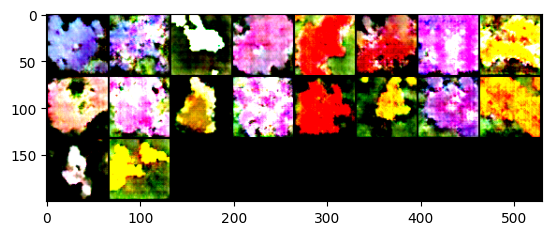

100%|██████████| 103/103 [00:10<00:00, 10.17it/s]


epoch: 22, lossD:0.587850469517187, lossG:7.809121770766175,lossG_fake:4.141907104010721, lossG_real:3.6672146644407104 ,equality:0.4746924395700103


evaluate:125.66124725341797,kid_mean:0.08793739229440689, kid_std:0.047607164829969406,kid_:(tensor(0.0879), tensor(0.0476))


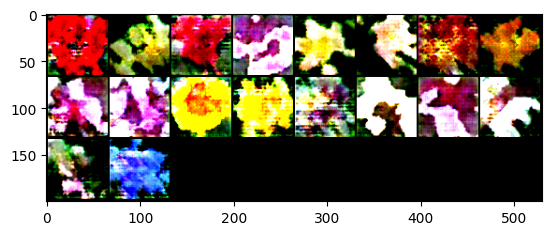

100%|██████████| 103/103 [00:10<00:00, 10.16it/s]


epoch: 23, lossD:0.5299728214740753, lossG:7.92485316748758,lossG_fake:4.256232532482703, lossG_real:3.668620634426191 ,equality:0.5876118980565121


evaluate:122.17093658447266,kid_mean:0.0967041403055191, kid_std:0.04723585397005081,kid_:(tensor(0.0967), tensor(0.0472))


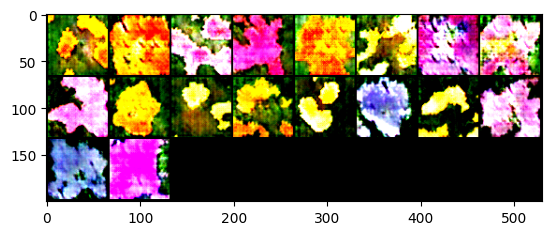

100%|██████████| 103/103 [00:10<00:00, 10.14it/s]


epoch: 24, lossD:0.44279478880965595, lossG:8.280495139001642,lossG_fake:4.466984473385857, lossG_real:3.813510693971393 ,equality:0.6534737794144636


evaluate:123.60902404785156,kid_mean:0.0885530486702919, kid_std:0.04439811408519745,kid_:(tensor(0.0886), tensor(0.0444))


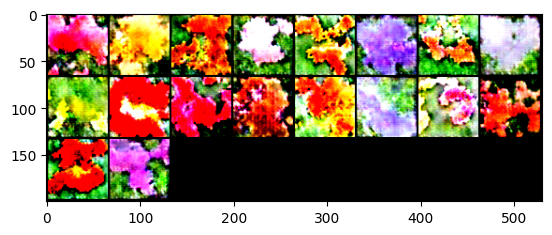

100%|██████████| 103/103 [00:10<00:00, 10.13it/s]


epoch: 25, lossD:0.39923107969457083, lossG:8.590444782405223,lossG_fake:4.581121794228415, lossG_real:4.0093230026439555 ,equality:0.5717987915844596


evaluate:122.20482635498047,kid_mean:0.08966156840324402, kid_std:0.05167204514145851,kid_:(tensor(0.0897), tensor(0.0517))


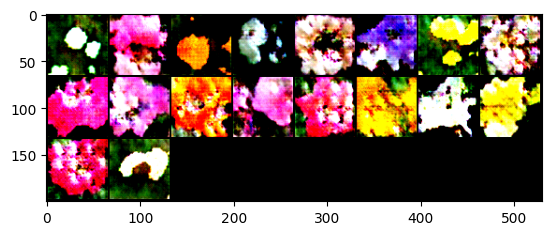

100%|██████████| 103/103 [00:10<00:00, 10.14it/s]


epoch: 26, lossD:0.43564167714596375, lossG:8.406311303666495,lossG_fake:4.421072863838048, lossG_real:3.9852384461939914 ,equality:0.4358344176440565


evaluate:119.57103729248047,kid_mean:0.0843697041273117, kid_std:0.0420854277908802,kid_:(tensor(0.0844), tensor(0.0421))


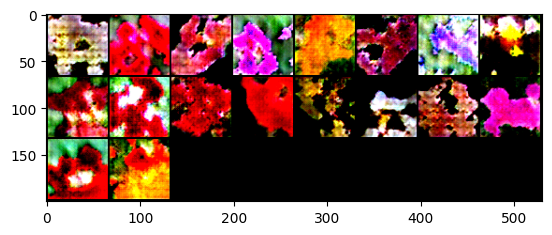

100%|██████████| 103/103 [00:10<00:00, 10.13it/s]


epoch: 27, lossD:0.3597185176806253, lossG:8.593795165274907,lossG_fake:4.548811422968374, lossG_real:4.044983753880251 ,equality:0.5038276690881229


evaluate:120.2364730834961,kid_mean:0.08528592437505722, kid_std:0.03910551965236664,kid_:(tensor(0.0853), tensor(0.0391))


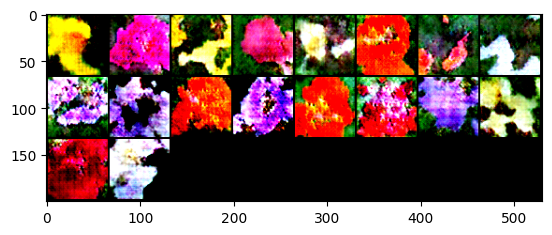

100%|██████████| 103/103 [00:10<00:00, 10.16it/s]


epoch: 28, lossD:0.40545967206792927, lossG:8.731950283050537,lossG_fake:4.579709610892731, lossG_real:4.152240656533287 ,equality:0.4274689543594441


evaluate:121.67691802978516,kid_mean:0.09003297984600067, kid_std:0.04387814924120903,kid_:(tensor(0.0900), tensor(0.0439))


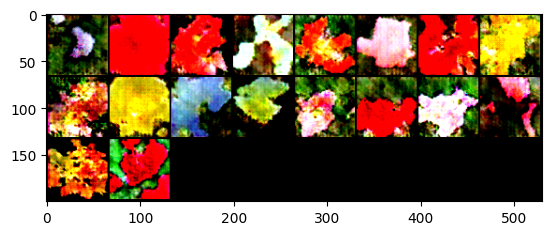

100%|██████████| 103/103 [00:10<00:00, 10.20it/s]


epoch: 29, lossD:0.45764562822155, lossG:9.005596934012996,lossG_fake:4.812159702615831, lossG_real:4.193437205934988 ,equality:0.6187224966808431


evaluate:121.30612182617188,kid_mean:0.09314962476491928, kid_std:0.0444071963429451,kid_:(tensor(0.0931), tensor(0.0444))


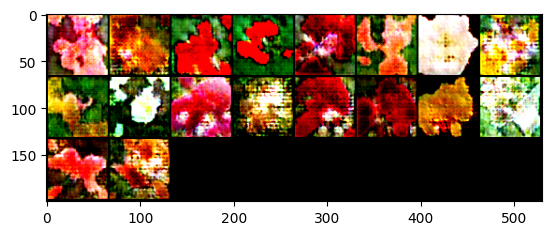

100%|██████████| 103/103 [00:10<00:00, 10.15it/s]


epoch: 30, lossD:0.3327580066488206, lossG:8.852195665674301,lossG_fake:4.572279769240073, lossG_real:4.27991595777493 ,equality:0.292363811465143


evaluate:121.27851104736328,kid_mean:0.07717231661081314, kid_std:0.04057275131344795,kid_:(tensor(0.0772), tensor(0.0406))


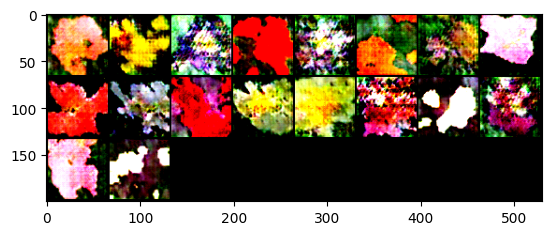

100%|██████████| 103/103 [00:10<00:00, 10.14it/s]


epoch: 31, lossD:0.2911818260959919, lossG:9.211498630857005,lossG_fake:4.888783263928682, lossG_real:4.32271540512159 ,equality:0.5660678588070915


evaluate:120.84161376953125,kid_mean:0.09231643378734589, kid_std:0.046267397701740265,kid_:(tensor(0.0923), tensor(0.0463))


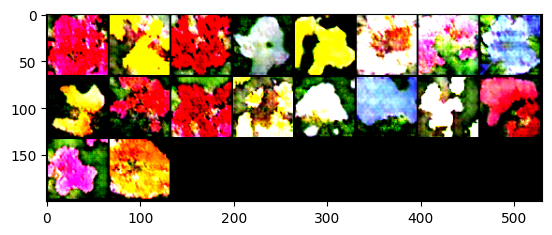

100%|██████████| 103/103 [00:10<00:00, 10.17it/s]


epoch: 32, lossD:0.317955039857516, lossG:9.344077915821261,lossG_fake:4.929416253728774, lossG_real:4.414661660935115 ,equality:0.5147545927936585


evaluate:118.35602569580078,kid_mean:0.0874842181801796, kid_std:0.04117762669920921,kid_:(tensor(0.0875), tensor(0.0412))


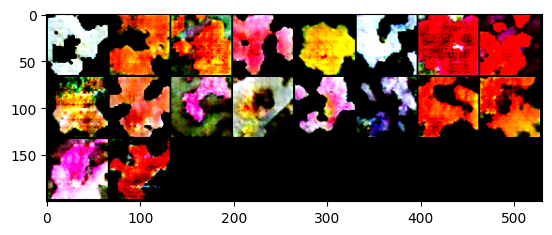

100%|██████████| 103/103 [00:10<00:00, 10.16it/s]


epoch: 33, lossD:0.2631447330587408, lossG:9.215671733745094,lossG_fake:4.783528466826504, lossG_real:4.432143231040066 ,equality:0.351385235786438


evaluate:117.84965515136719,kid_mean:0.08960124850273132, kid_std:0.04393455386161804,kid_:(tensor(0.0896), tensor(0.0439))


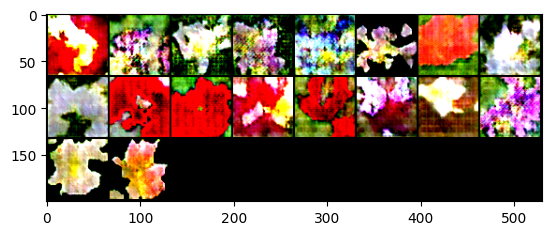

100%|██████████| 103/103 [00:10<00:00, 10.14it/s]


epoch: 34, lossD:0.32979363837794773, lossG:10.04004218277422,lossG_fake:5.287720780928158, lossG_real:4.752321362929437 ,equality:0.5353994179987209


evaluate:114.07429504394531,kid_mean:0.08354374021291733, kid_std:0.05132028087973595,kid_:(tensor(0.0835), tensor(0.0513))


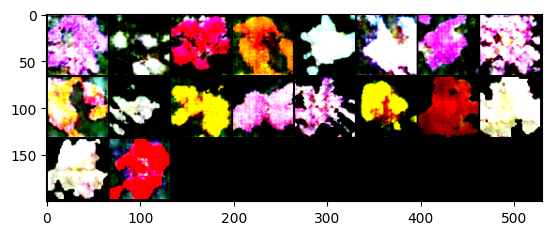

100%|██████████| 103/103 [00:10<00:00, 10.15it/s]


epoch: 35, lossD:0.34172224389045563, lossG:9.559189532566997,lossG_fake:4.917703483868571, lossG_real:4.641486040596823 ,equality:0.27621744327174813


evaluate:114.95903778076172,kid_mean:0.07931109517812729, kid_std:0.04328598454594612,kid_:(tensor(0.0793), tensor(0.0433))


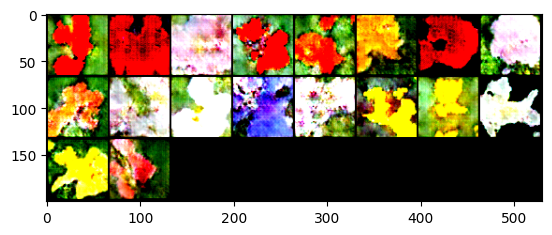

100%|██████████| 103/103 [00:10<00:00, 10.21it/s]


epoch: 36, lossD:0.1833120570020768, lossG:9.631680493215912,lossG_fake:5.032020975085138, lossG_real:4.5996594915112246 ,equality:0.4323614835739136


evaluate:115.03263854980469,kid_mean:0.09251032769680023, kid_std:0.049721553921699524,kid_:(tensor(0.0925), tensor(0.0497))


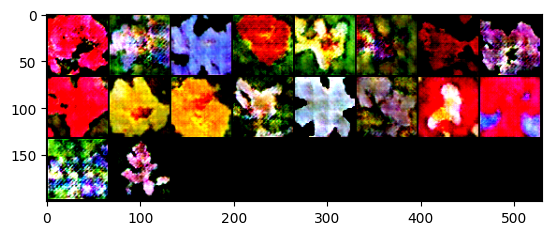

100%|██████████| 103/103 [00:10<00:00, 10.16it/s]


epoch: 37, lossD:0.4165910955843995, lossG:10.208872938619077,lossG_fake:5.422640087824424, lossG_real:4.786232828515248 ,equality:0.6364072593091761


evaluate:114.36341857910156,kid_mean:0.08277289569377899, kid_std:0.04167983680963516,kid_:(tensor(0.0828), tensor(0.0417))


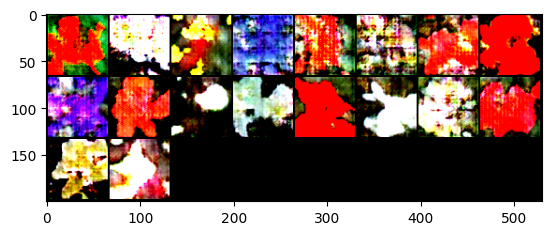

100%|██████████| 103/103 [00:10<00:00, 10.18it/s]


epoch: 38, lossD:0.29547585134656684, lossG:10.50258891096393,lossG_fake:5.6230706780859565, lossG_real:4.87951821493871 ,equality:0.7435524631472461


evaluate:110.27471160888672,kid_mean:0.07527640461921692, kid_std:0.03865455090999603,kid_:(tensor(0.0753), tensor(0.0387))


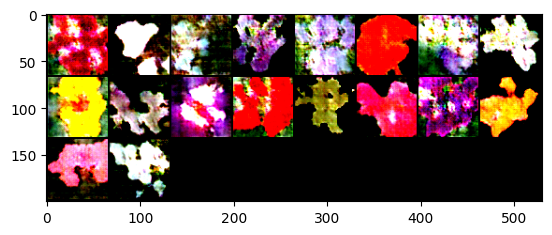

100%|██████████| 103/103 [00:10<00:00, 10.17it/s]


epoch: 39, lossD:0.2355258637514797, lossG:10.197007660726898,lossG_fake:5.443665161873531, lossG_real:4.753342518239346 ,equality:0.6903226436341852


evaluate:111.65081024169922,kid_mean:0.08135898411273956, kid_std:0.04237621650099754,kid_:(tensor(0.0814), tensor(0.0424))


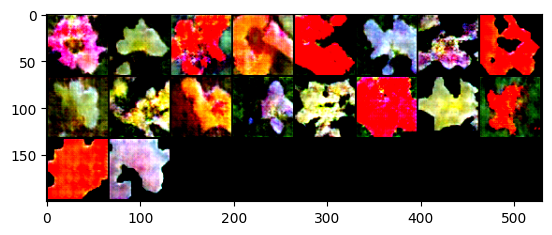

100%|██████████| 103/103 [00:10<00:00, 10.18it/s]


epoch: 40, lossD:0.15639023627471, lossG:10.70286412840908,lossG_fake:5.598069827533463, lossG_real:5.104794305505105 ,equality:0.493275522028358


evaluate:111.64600372314453,kid_mean:0.08101416379213333, kid_std:0.03658262640237808,kid_:(tensor(0.0810), tensor(0.0366))


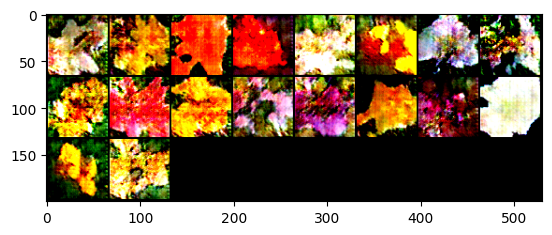

100%|██████████| 103/103 [00:10<00:00, 10.14it/s]


epoch: 41, lossD:0.23676708664347246, lossG:10.688603336371264,lossG_fake:5.6546487964472725, lossG_real:5.033954530086332 ,equality:0.6206942663609407


evaluate:112.43921661376953,kid_mean:0.07998300343751907, kid_std:0.04228902980685234,kid_:(tensor(0.0800), tensor(0.0423))


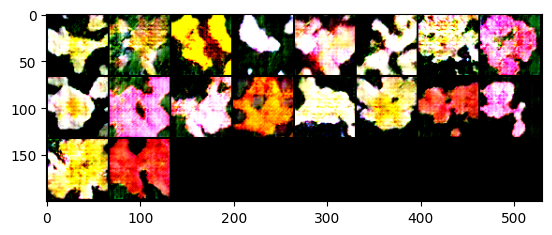

100%|██████████| 103/103 [00:10<00:00, 10.21it/s]


epoch: 42, lossD:0.2331631378207392, lossG:10.688864994974969,lossG_fake:5.677683131208697, lossG_real:5.011181891543194 ,equality:0.6665012396655037


evaluate:111.7650375366211,kid_mean:0.08103053271770477, kid_std:0.043975356966257095,kid_:(tensor(0.0810), tensor(0.0440))


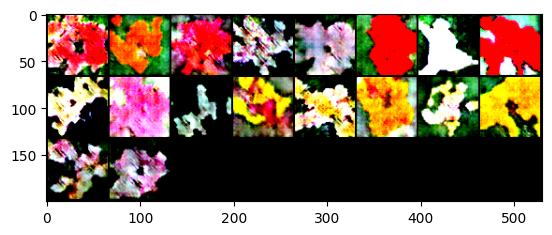

100%|██████████| 103/103 [00:10<00:00, 10.16it/s]


epoch: 43, lossD:0.17641459947940216, lossG:10.706074501704244,lossG_fake:5.6259069743665675, lossG_real:5.080167513449215 ,equality:0.5457394609173525


evaluate:113.5534439086914,kid_mean:0.086455337703228, kid_std:0.042495954781770706,kid_:(tensor(0.0865), tensor(0.0425))


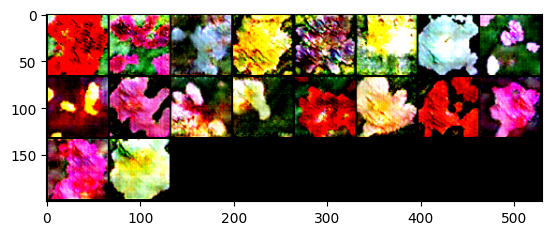

100%|██████████| 103/103 [00:10<00:00, 10.13it/s]


epoch: 44, lossD:0.18594893672078558, lossG:10.291245247553853,lossG_fake:5.367003192600695, lossG_real:4.924242031227037 ,equality:0.4427611613736575


evaluate:113.48137664794922,kid_mean:0.07992412894964218, kid_std:0.0399509035050869,kid_:(tensor(0.0799), tensor(0.0400))


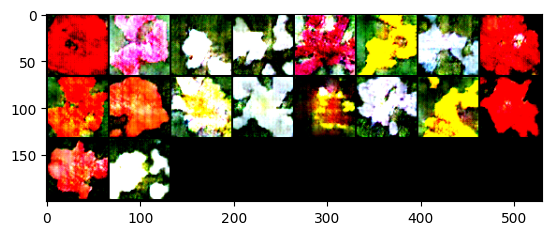

100%|██████████| 103/103 [00:10<00:00, 10.16it/s]


epoch: 45, lossD:0.21312044043708772, lossG:10.596751407512183,lossG_fake:5.560164443497519, lossG_real:5.036586979060497 ,equality:0.5235774644370217


evaluate:114.53256225585938,kid_mean:0.0826951414346695, kid_std:0.041380248963832855,kid_:(tensor(0.0827), tensor(0.0414))


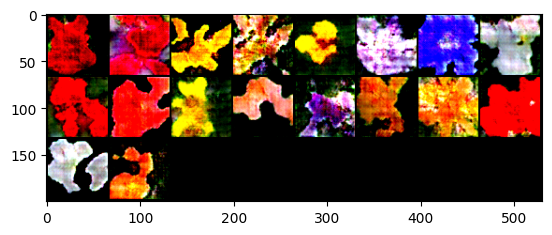

100%|██████████| 103/103 [00:10<00:00, 10.15it/s]


epoch: 46, lossD:0.1771061753727568, lossG:10.759098960357962,lossG_fake:5.551144840647873, lossG_real:5.207954138228037 ,equality:0.34319070241983596


evaluate:115.53494262695312,kid_mean:0.084385946393013, kid_std:0.046997372061014175,kid_:(tensor(0.0844), tensor(0.0470))


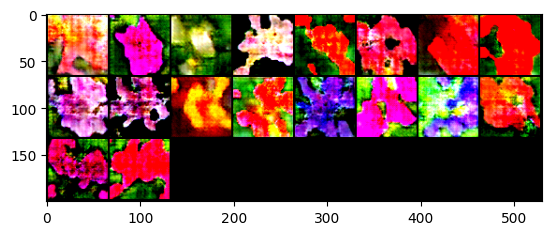

100%|██████████| 103/103 [00:10<00:00, 10.15it/s]


epoch: 47, lossD:0.2071905260525861, lossG:11.197906475622677,lossG_fake:6.071148895522923, lossG_real:5.126757550008088 ,equality:0.944391345514835


evaluate:116.04764556884766,kid_mean:0.09136033803224564, kid_std:0.04741692543029785,kid_:(tensor(0.0914), tensor(0.0474))


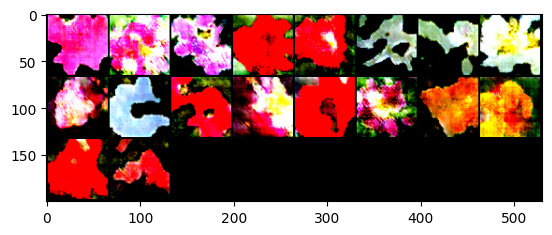

100%|██████████| 103/103 [00:10<00:00, 10.09it/s]


epoch: 48, lossD:0.324883268549315, lossG:11.239236109465072,lossG_fake:5.933355605139316, lossG_real:5.305880554671426 ,equality:0.6274750504678899


evaluate:116.16732025146484,kid_mean:0.08391103893518448, kid_std:0.03906795382499695,kid_:(tensor(0.0839), tensor(0.0391))


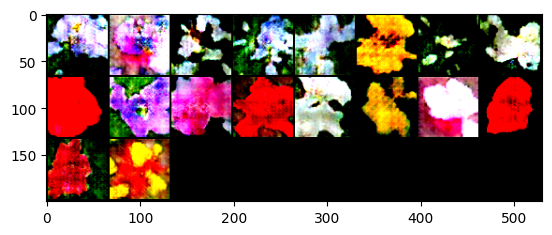

100%|██████████| 103/103 [00:10<00:00, 10.15it/s]


epoch: 49, lossD:0.17107928119310475, lossG:10.485864241146347,lossG_fake:5.448678130085028, lossG_real:5.037186157356188 ,equality:0.4114919727288404


evaluate:116.26667785644531,kid_mean:0.08193525671958923, kid_std:0.05253744125366211,kid_:(tensor(0.0819), tensor(0.0525))


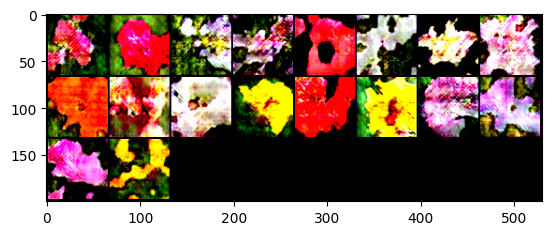

In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))


        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()

        #train generator

        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake


        lossG.backward()
        optimizerG.step()

        # save loss

        running_lossD += lossD.item()
        running_lossG += lossG.item()

        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()



    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()



    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

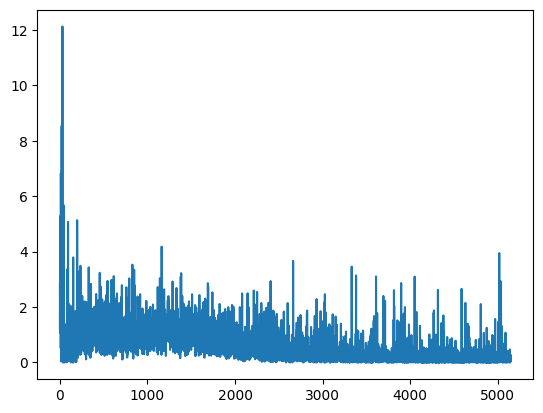

In [45]:
plt.plot(raw_lossesD)

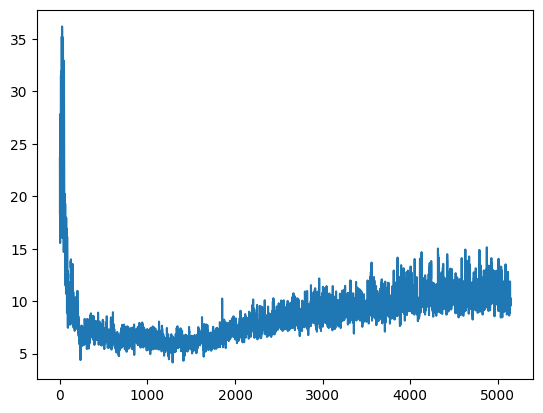

In [46]:
plt.plot(raw_lossesG)

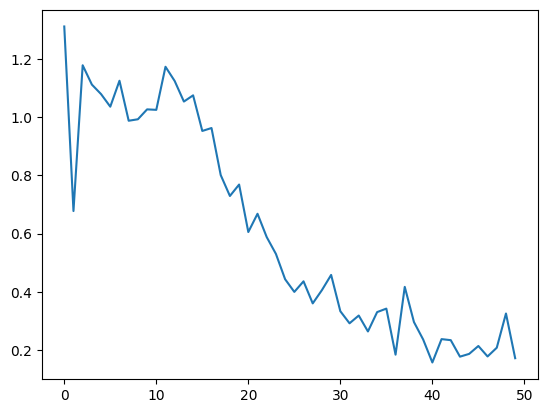

In [47]:
plt.plot(lossesD)

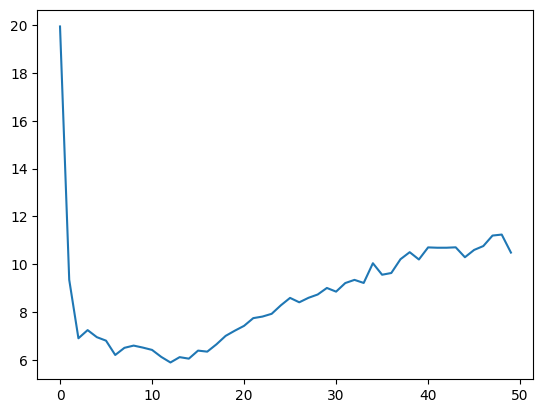

In [48]:
plt.plot(lossesG)

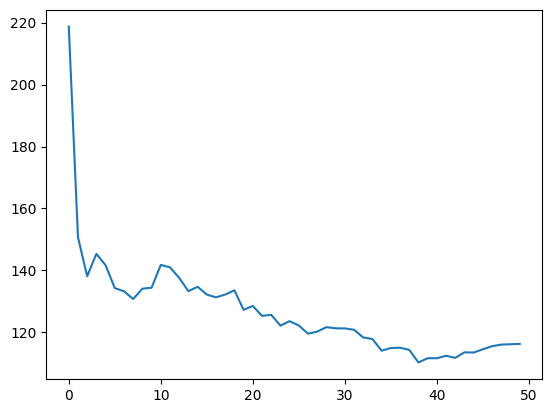

In [49]:
plt.plot(fid_)

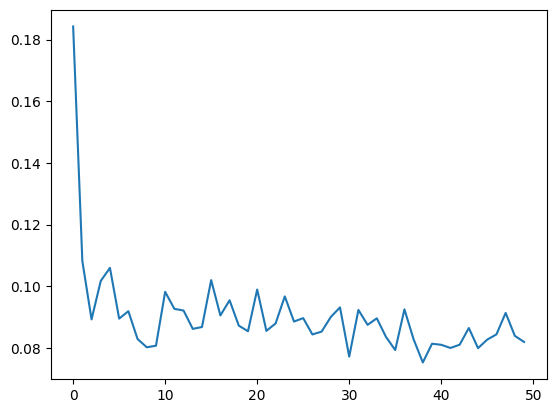

In [50]:
plt.plot(kid_mean_)

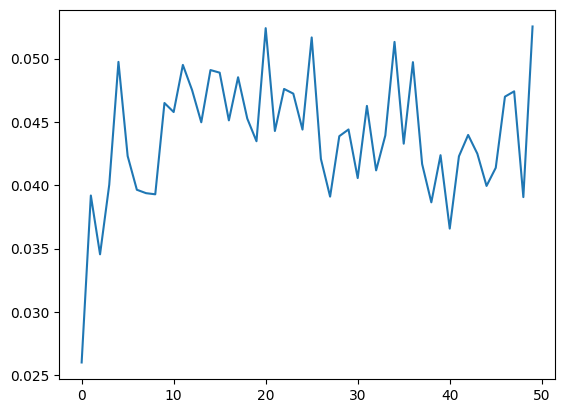

In [51]:
plt.plot(kid_std_)

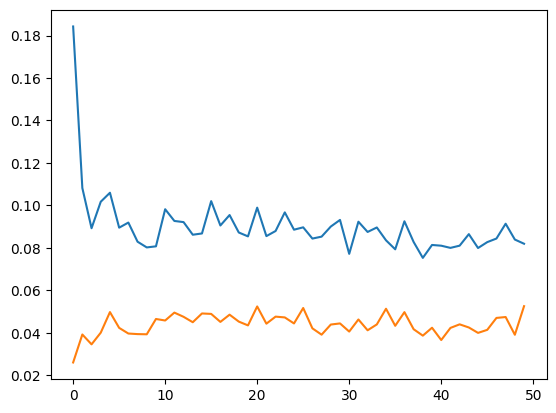

In [52]:
plt.plot(kid_score)

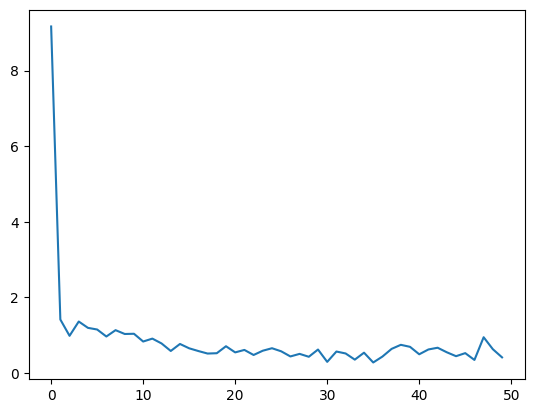

In [53]:
plt.plot(d_equality)

In [54]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0815), tensor(0.0372))